In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import zipfile
import os
import glob

import json
import pickle
from datetime import datetime, date
from scipy import interpolate

In [3]:
os.listdir(r'/content/drive/MyDrive/ad_ml')

['players.pkl',
 'results.pkl',
 'tournaments.pkl',
 'train.pkl',
 'test.pkl',
 'tournament-tours-5462-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-5553-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-5554-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-5703-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-6254-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-6249-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-6090-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-6085-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-6026-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-5864-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-5760-17-Apr-2023.xlsx - Worksheet.csv',
 'tournament-tours-6255-17-Apr-2023.xlsx - Worksheet.csv']

In [4]:
dir_path = r'/content/drive/MyDrive/ad_ml'
# path = r'/content/drive/MyDrive/chgk.zip'

# try:
#     os.mkdir(dir_path)
# except FileExistsError:
#     pass
# with zipfile.ZipFile(path, 'r') as zip_ref:
#     zip_ref.extractall(dir_path)

In [5]:
restart = False

with open(os.path.join(dir_path, 'tournaments.pkl'), 'rb') as file:
    tournaments = pickle.load(file)
tournaments = pd.DataFrame(tournaments).T.set_index('id')

if restart:
    with open(os.path.join(dir_path, 'results.pkl'), 'rb') as file:
        results = pickle.load(file)

with open(os.path.join(dir_path, 'players.pkl'), 'rb') as file:
    players = pickle.load(file)
players = pd.DataFrame(players).T.set_index('id')

In [6]:

tourn_train = tournaments[tournaments.dateStart.map(lambda d: datetime.fromisoformat(d).year == 2019)]
tourn_test = tournaments[tournaments.dateStart.map(lambda d: datetime.fromisoformat(d).year == 2020)]

In [7]:
players[players.surname.str.contains('Вассерман')]

,name,patronymic,surname
id,,,
5195,Анатолий,Александрович,Вассерман
5196,Евгений,,Вассерман
5197,Макс,,Вассерман
5198,Михаил,,Вассерман
5199,Юлий,Владимирович,Вассерман
40895,Александр,,Вассерман
202294,Илья,Семёнович,Вассерман


In [8]:
train = pd.DataFrame()
def construct(results):
    data = pd.DataFrame()
    for k, v in results.items():
        
        for team in v:

            w = pd.json_normalize(team)
            try:
                w = w.explode('teamMembers')[['mask', 'teamMembers', 'team.id']].copy()
            except KeyError:
                continue
            w['player_id'] = w.teamMembers.map(
                lambda p: float('nan') 
                if isinstance(p, float) 
                else p['player']['id']
            )
            w = w[['mask', 'player_id', 'team.id']]
            w['tourn_id'] = k

            data = pd.concat((data, w), axis=0)
    return data



In [9]:

if restart:
    results_train = {k: v for k, v in results.items() if k in tourn_train.index.tolist()}
    results_test = {k: v for k, v in results.items() if k in tourn_test.index.tolist()}

    train = construct(results_train)
    test = construct(results_test)

    with open(os.path.join(dir_path, 'train.pkl'), 'wb') as file:
        pickle.dump(train, file)
    with open(os.path.join(dir_path, 'test.pkl'), 'wb') as file:
        pickle.dump(test, file)
else:
    with open(os.path.join(dir_path, 'train.pkl'), 'rb') as file:
        train = pickle.load(file)
    with open(os.path.join(dir_path, 'test.pkl'), 'rb') as file:
        test = pickle.load(file)

In [10]:
print(train.player_id.unique().shape)
print(test.player_id.unique().shape)

(59217,)
(29243,)


In [11]:
train = train[train['mask'].notna()]
train['mask'] = train['mask'].str.replace('X', '')
train.head()

<ipython-input-11-a355b5b5423c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['mask'] = train['mask'].str.replace('X', '')


,mask,player_id,team.id,tourn_id
0,111111111011111110111111111100010010,6212.0,45556,4772
0,111111111011111110111111111100010010,18332.0,45556,4772
0,111111111011111110111111111100010010,18036.0,45556,4772
0,111111111011111110111111111100010010,22799.0,45556,4772
0,111111111011111110111111111100010010,15456.0,45556,4772


In [12]:
# train[train['mask'].str.contains('X')]
# train[train.tourn_id == 4986]

train[train['mask'].str.contains('?', regex=False)]
train[((train.tourn_id == 5141) & (train['mask'].str.contains('?', regex=False)))]

,mask,player_id,team.id,tourn_id
0,11111010?11100011001100011110001000100011010111,43240.0,27610,5141
0,11111010?11100011001100011110001000100011010111,42947.0,27610,5141
0,11111010?11100011001100011110001000100011010111,101957.0,27610,5141
0,11111010?11100011001100011110001000100011010111,128907.0,27610,5141
0,11111010?11100011001100011110001000100011010111,127458.0,27610,5141
0,110011100?0100011001010010010000001110000110110,92618.0,47183,5141
0,110011100?0100011001010010010000001110000110110,128481.0,47183,5141
0,110011100?0100011001010010010000001110000110110,63200.0,47183,5141
0,110011100?0100011001010010010000001110000110110,88263.0,47183,5141
0,110011100?0100011001010010010000001110000110110,100742.0,47183,5141


In [13]:
print(train[train.tourn_id == 5462]["mask"].str.len().describe())
# with pd.option_context('display.max_rows', 50, 'display.max_columns', 5, 'display.max_colwidth', 512):
#    print(train[train.tourn_id == 5462]["mask"].head(50))
print()

df1 = pd.DataFrame(train['tourn_id'])
df1['len_mask'] = train["mask"].str.len()

df1 = df1.groupby(['tourn_id']).agg({'len_mask': lambda x: list(x.unique())})

df2 = df1[df1.len_mask.map(lambda x: len(x)) > 1]
print(df2)

print('-----------------------------------------------------------')
print('-----------------------------------------------------------')

print("", len(df2) / train.tourn_id.unique().shape[0])

print("", len(df2.merge(train, left_on='tourn_id', right_on='tourn_id')) / len(train))

count    192.000000
mean      60.375000
std       31.256162
min       36.000000
25%       36.000000
50%       36.000000
75%      108.000000
max      108.000000
Name: mask, dtype: float64

                                                   len_mask
tourn_id                                                   
5462                                          [108, 72, 36]
5553      [234, 189, 198, 144, 162, 117, 126, 153, 108, ...
5554      [234, 198, 189, 153, 117, 126, 162, 90, 81, 72...
5703                                               [36, 24]
5760                                     [144, 108, 72, 36]
5864                                  [126, 90, 81, 36, 45]
6026                                         [100, 112, 98]
6085         [269, 224, 179, 180, 135, 134, 90, 89, 45, 44]
6090                                   [435, 434, 433, 431]
6249                      [252, 216, 180, 144, 108, 72, 36]
6254                           [216, 180, 144, 108, 72, 36]
6255      [215, 180, 179, 143, 1

## TODO:
разбить турнир с разным числом вопросов в турах на несколько турниров, добавить в train

In [24]:
tourn_w_rounds = df2.index.tolist()

In [22]:
tourn_w_rounds = df2.index.tolist()
tourn_w_rounds  # [5462, 5553, 5554, 5703, 5760, 5864, 6026, 6085, 6090, 6249, 6254, 6255]
df_tourn_w_rounds = pd.DataFrame(columns=['mask',	'team.id', 'player.id',	'tourn_id'])
for file in glob.glob(dir_path + '/*.csv'):
    
    tourn_id_str = file[46:50]
    # df_tourn_w_rounds = pd.concat((df_tourn_w_rounds, ), axis=0)
    df3 = pd.read_csv(file)
    for round_id in df3['Тур'].unique():
        df_round = df3[df3['Тур'] == round_id]
        df_round.dropna(axis=1, inplace=True, how='any')
        df_round['tourn_id'] = 
df_tourn_w_rounds

SyntaxError: ignored

In [15]:
train['mask'].str.len().max()

500

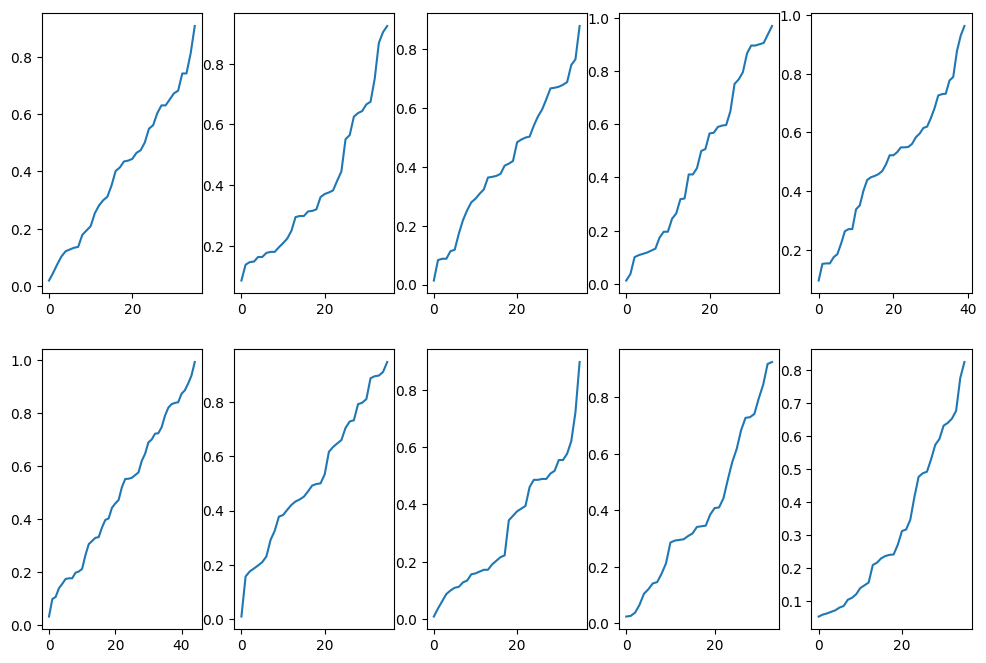

In [16]:
sample = np.random.choice(train.tourn_id.unique(), 10)
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(12, 8)
for idx, tourn_id in enumerate(sample):
    tourn = train[train.tourn_id == tourn_id]
    ans_mask = tourn["mask"].map(lambda x: [int(i) if i in '01' else 0.5 for i in x]).tolist()
    columns=[str(i) for i in range(len(ans_mask[0]))]
    ans_arr = pd.DataFrame(ans_mask, columns=columns).to_numpy()

    ans_rate = pd.DataFrame(ans_mask, columns=columns).to_numpy().sum(axis=0) / ans_arr.shape[0]

    # interpolate.interp1d
    ax[idx // 5, idx % 5].plot(np.sort(ans_rate[((ans_rate > 0) & (ans_rate < 0.99999999))]))

## TODO: 
в графиках выше считается, что все игроки команды, давшей правильный ответ, взяли вопрос. По оси $y$ доля ответивших игроков, по $x$ порядковый номер вопроса по убыванию сложности. Надо построить график с долей ответивших команд

In [17]:

from sklearn.linear_model import LinearRegression, LogisticRegression

def get_complexity_data(tourn):
    if tourn["mask"].str.len().unique().size > 1:
        print(tourn.tourn_id.values[0])
    ans_mask = tourn["mask"].map(lambda x: [int(i) if i in '01' else 0.5 for i in x]).tolist()
    columns=[str(i) for i in range(len(ans_mask[0]))]
    ans_arr = pd.DataFrame(ans_mask, columns=columns).to_numpy()
    
    q_rate = ans_arr.sum(axis=0) / ans_arr.shape[0]

    return ans_arr, q_rate



## TODO:
Переделать графики выше с использованием $\texttt{get_complexity_function}$ . Сделать столько же сэмплов с линейным предсказанием простоты вопросов.

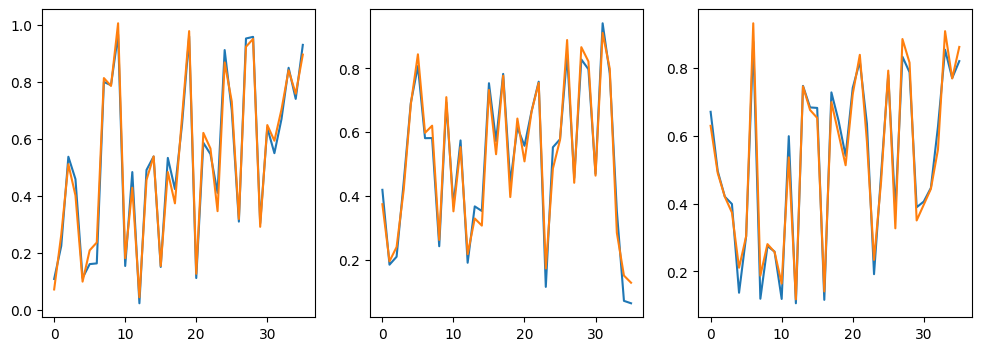

In [18]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
for idx, tourn_id in enumerate(train.tourn_id.unique()[:3]):
    batch = train[train.tourn_id == tourn_id]
    ans_arr, q_rate = get_complexity_data(batch)
    indices = np.argsort(1 - q_rate)
    inv_indices = np.empty_like(indices)
    inv_indices[indices] = np.arange(len(indices))

    lr = LinearRegression()
    
    lr.fit(
        inv_indices.reshape(-1, 1), (1 - q_rate).reshape(-1, 1)
    )
    simplicity = lr.predict(inv_indices.reshape(-1, 1))
    
    ax[idx].plot(((1 - q_rate).flatten()))
    ax[idx].plot((simplicity.flatten()))



In [19]:
from scipy.sparse import coo_array

tourn_ids = train.tourn_id.unique()
player_ids = train.player_id.unique()
player_ids = player_ids[~np.isnan(player_ids)].astype(int)

rowX  = np.empty((40_000_000, 1))
colX  = np.empty((40_000_000, 1))
dataX = np.empty((40_000_000, 1))

rowy  = np.empty((20_000_000, 1))
coly  = np.empty((20_000_000, 1))
datay = np.empty((20_000_000, 1))

In [20]:


np.argwhere(player_ids == 5195).item()

5920

In [25]:
sample_idx = 0
for tourn_idx, tourn_id in enumerate(tourn_ids):
    if tourn_id in tourn_w_rounds: 
        continue
    tournament = train[train.tourn_id == tourn_id]
    ans_arr, q_rate = get_complexity_data(tournament)
    indices = np.argsort(1 - q_rate)
    inv_indices = np.empty_like(indices)
    inv_indices[indices] = np.arange(len(indices))

    lr = LinearRegression()
    
    lr.fit(
        inv_indices.reshape(-1, 1), (1 - q_rate).reshape(-1, 1)
    )
    simplicity = lr.predict(inv_indices.reshape(-1, 1))

    assert ans_arr.shape[0] == len(tournament)
    
    
    for player_id, answers in zip(tournament.player_id, ans_arr):
        try:
            player_id = int(player_id)
        except Exception as e:
            # print(e)
            # print(tourn_idx)  # tourn_idxes where player_id NaN: 4 22 251 379 383 384 395 462 546 564 573 597
            continue
        
        for question_rate, answer in zip(simplicity, answers):
            rowX[sample_idx] = sample_idx // 2
            colX[sample_idx] = tourn_idx
            dataX[sample_idx] = question_rate
        
            rowX[sample_idx + 1] = sample_idx // 2
            colX[sample_idx + 1] = len(tourn_ids) + np.argwhere(player_ids == player_id).item()
            dataX[sample_idx + 1] = 1

            rowy[sample_idx // 2] = sample_idx // 2
            coly[sample_idx // 2] = 0
            datay[sample_idx // 2] = answer

            sample_idx += 2

rowX = rowX[:sample_idx]
colX = colX[:sample_idx]
dataX = dataX[:sample_idx]

rowy = rowy[:sample_idx // 2]
coly = coly[:sample_idx // 2]
datay = datay[:sample_idx // 2]

In [26]:
X_train = coo_array( 
    (dataX.squeeze(), (rowX.squeeze(), colX.squeeze())), 
    shape=(sample_idx // 2, len(tourn_ids) + len(player_ids))
)


y_train  = coo_array( 
    (datay.squeeze(), (rowy.squeeze(), coly.squeeze())), 
    shape=(sample_idx // 2, 1)
)

In [27]:
X_train.shape, y_train.shape

((16153927, 59776), (16153927, 1))

In [28]:

lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train.todense(order='C').astype(int).ravel())

LogisticRegression(max_iter=10000)

In [29]:
rating_tourn = lr.coef_[0, :len(tourn_ids)]
rating_players = lr.coef_[0, len(tourn_ids):]
print(rating_tourn.min(), rating_tourn.max())
print(rating_players.min(), rating_players.max())

-14.145534589656382 0.0
-3.2467042153889993 3.901418386892662


In [34]:
players.loc[player_ids[np.argpartition(rating_players, -4)[-4:]]]


,name,patronymic,surname
id,,,
27822,Михаил,Владимирович,Савченков
27403,Максим,Михайлович,Руссо
28751,Иван,Николаевич,Семушин
4270,Александра,Владимировна,Брутер


In [56]:
from scipy import stats
res = []

for _, tourn_id in enumerate(test.tourn_id.unique()):
    df = pd.DataFrame()
    
    tourn = test[test.tourn_id == tourn_id].copy()
    tourn['performance_predicted'] = 0
    tourn['performance_actual'] = 0
    try:
        ans_arr, _ = get_complexity_data(tourn)
    except TypeError:
        continue
    assert len(tourn) == ans_arr.shape[0]
    for idx, answers in zip(range(len(tourn)), ans_arr):
        try:
            player_idx = np.argwhere(int(tourn.iloc[idx, 1]) == player_ids).item()
        except ValueError:
            tourn.iloc[idx, 4] = np.nan
        else:
            #
            tourn.iloc[idx, 4] = rating_players[player_idx]
        
        tourn.iloc[idx, 5] = answers.sum()

    tourn.dropna(axis=0, inplace=True, how='any')
    # tourn.set_index('player_id')
    
    res.append([
        stats.spearmanr(tourn['performance_actual'], tourn['performance_predicted']).statistic, 
        stats.kendalltau(tourn['performance_actual'], tourn['performance_predicted']).statistic
    ])
res = np.asarray(res)
np.nanmean(res, axis=0) # array([0.72223742, 0.55741029])


5477
5705
5710
5733
6172
6265
6307
6308


/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [61]:
np.nanmean(res, axis=0)

array([0.72223742, 0.55741029])